In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import mplcyberpunk
import seaborn as sns
import scipy as sp
import scipy.stats as stats
from typing import List, Dict, Callable

plt.style.use('ggplot')
# plt.style.use("cyberpunk")

import os
os.getcwd()

'/home/jovyan/work/Fraud_Detection'

In [3]:
# Import Custom Modules
from src.cleaner import *

In [4]:
# Import Data
data = pd.read_json('data/data.json')

In [5]:
# Copy data to avoid collisions
df = clean_with_target(data.copy())

# One Hot Encoding
df = ohe_existence(df, ['email_domain', 'payee_name'])
# df.drop(columns=['venue_latitude', 'venue_longitude'], inplace=True)
df.dropna(inplace=True)

In [6]:
df

,channels,country,currency,delivery_method,fb_published,has_logo,listed,payout_type,user_created,user_type,venue_country,venue_latitude,venue_longitude,fraud,n_previous_payouts,event_duration,event_till_publish,user_event_lifespan,has_email_domain,has_payee_name
0,5,840,840,0.0,0,0,1,3,1259613950,1,840,25.777471,-80.133433,1,0,36000,370132.0,3125756,1,0
1,0,840,840,1.0,0,1,0,2,1280942776,3,840,32.776566,-79.930922,0,49,32400,625.0,12889894,1,1
2,8,840,840,1.0,0,0,1,2,1272559388,3,840,33.944201,-118.080419,0,36,27000,952.0,18531568,1,1
4,11,840,840,0.0,1,0,1,2,1288984065,3,840,42.353848,-71.044276,0,49,28800,300.0,3010601,1,1
5,6,840,840,0.0,0,1,1,2,1268579110,1,840,38.209797,-84.558831,0,5,10800,62.0,25842700,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14332,0,840,840,0.0,0,1,0,3,1360297993,1,840,39.373780,-76.629921,1,0,25200,759.0,0,1,0
14333,5,840,840,1.0,0,0,1,2,1241625346,4,840,32.778906,-117.209791,0,5,10800,3205.0,118741696,1,1
14334,13,-1,840,0.0,1,1,1,1,1353386971,4,840,30.041819,-89.957130,0,1,21600,736511.0,7213359,1,0
14335,8,840,840,0.0,0,1,1,1,1290204991,3,840,40.862283,-73.911363,0,128,39600,268.0,70171294,1,0


# Scale Data

In [7]:
from sklearn.preprocessing import StandardScaler

columns = [
'channels',
'country',
'currency',
'delivery_method',
'fb_published',
'has_logo',
'listed',
'payout_type',
'user_created',
'user_type',
'venue_country',
'venue_latitude',
'venue_longitude',
'n_previous_payouts',
'event_duration',
'event_till_publish',
'user_event_lifespan',
'has_email_domain',
'has_payee_name']

for col in columns:
    df[col] = StandardScaler().fit_transform(df[col].values.reshape(-1,1))

In [8]:
df.head(2)

,channels,country,currency,delivery_method,fb_published,has_logo,listed,payout_type,user_created,user_type,venue_country,venue_latitude,venue_longitude,fraud,n_previous_payouts,event_duration,event_till_publish,user_event_lifespan,has_email_domain,has_payee_name
0,-0.370302,0.495516,0.418115,-0.758794,-0.398258,-2.471547,0.391864,3.506484,-1.301275,-1.065429,0.544245,-0.466549,-0.308819,1,-0.323043,-0.103682,0.054000,-0.818910,0.0,-0.544008
1,-1.702130,0.495516,0.418115,0.911158,-0.398258,0.404605,-2.551903,1.476406,-0.781658,0.159812,0.544245,-0.120278,-0.305778,0,-0.121333,-0.105504,0.048908,-0.549628,0.0,1.838209


In [9]:
from sklearn.model_selection import train_test_split

# Create X, y targets
y = df.pop('fraud')
X = df
# Train Test Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

In [10]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [11]:
# Construct Metrics

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS):
    model = Sequential([Dense( 16, activation='relu', input_shape=(19,)), Dropout(0.5), Dense(1, activation='sigmoid',)])

    model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=metrics)

    return model

In [12]:
# Initialising the ANN
# nn_classifier = make_model()
nn_classifier = Sequential()

# Adding the input layer and the first hidden layer
nn_classifier.add(Dense(units = 20 , kernel_initializer = 'uniform', activation = 'relu', input_dim = 19))

# Adding the second hidden layer
nn_classifier.add(Dense(units = 20 , kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
nn_classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
nn_classifier.compile(optimizer = 'adam', loss = 'mse', metrics = METRICS)

In [13]:
# Fitting the ANN to the Training set
nn_classifier.fit(X_train, y_train, batch_size = 32, epochs = 50)

Epoch 1/50
6614/6614 [==============================] - 1s 111us/step - loss: 0.1221 - tp: 0.0000e+00 - fp: 20.0000 - tn: 6154.0000 - fn: 440.0000 - accuracy: 0.9305 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6215
Epoch 2/50
6614/6614 [==============================] - 0s 75us/step - loss: 0.0457 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 6174.0000 - fn: 440.0000 - accuracy: 0.9335 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9132
Epoch 3/50
6614/6614 [==============================] - 0s 71us/step - loss: 0.0416 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 6174.0000 - fn: 440.0000 - accuracy: 0.9335 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9249
Epoch 4/50
6614/6614 [==============================] - 0s 70us/step - loss: 0.0384 - tp: 107.0000 - fp: 1.0000 - tn: 6173.0000 - fn: 333.0000 - accuracy: 0.9495 - precision: 0.9907 - recall: 0.2432 - auc: 0.9297
Epoch 5/50
6614/6614 [==============================] - 0s 60us/step - loss: 0.0355 - tp: 175.0000 - fp: 22.

# Prediction

In [14]:
# Predicting the Test set results
y_pred = nn_classifier.predict(X_test)
y_pred = (y_pred > 0.5)
score = nn_classifier.evaluate(X_test, y_test)
score

6615/6615 [==============================] - 0s 56us/step


[0.035034124830946076,
 267.0,
 102.0,
 6055.0,
 191.0,
 0.9557067155838013,
 0.7235772609710693,
 0.5829694271087646,
 0.9064682722091675]

# Report

In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, zero_division=False))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      6157
           1       0.72      0.58      0.65       458

    accuracy                           0.96      6615
   macro avg       0.85      0.78      0.81      6615
weighted avg       0.95      0.96      0.95      6615



# ROC Curve

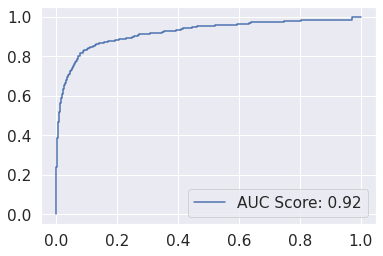

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = nn_classifier.predict_proba(X_test)

# Get ROC Curve
auc = round(roc_auc_score(y_test, y_pred_proba), 2)
fpr, tpr, thresh = roc_curve(y_test, y_pred_proba)


plt.plot(fpr, tpr, label=f'AUC Score: {auc}')

plt.legend()

# Confusion Matrix

Test Data Accuracy: 0.9557


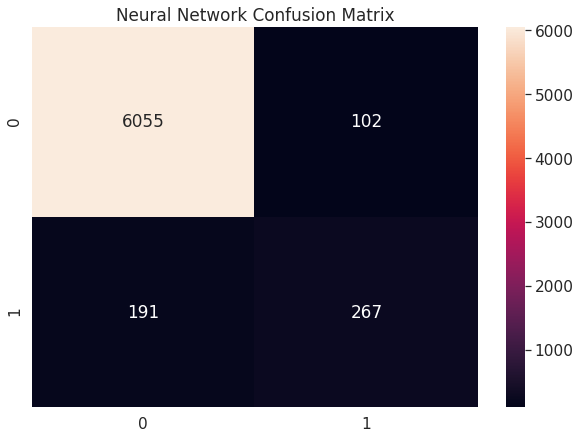

In [16]:
import seaborn as sn
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4, )
sn.heatmap(df_cm, annot=True, fmt='g')
plt.title('Neural Network Confusion Matrix')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

# Test on API Call

In [17]:
from src.api_client import *

event_api = EventAPIClient()

def _call(client:object) -> pd.DataFrame:
    return client.get_data()

sample_call = _call(event_api)

sample_df = pd.DataFrame(sample_call)
sample_df

,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,event_end,event_published,...,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state,sequence_number
0,978,5,US,USD,0.0,"<p><span style=""color: #333333; font-family: '...",humblebeast.com,1358973880,1359437400,1.358974e+09,...,285,1334367598,4,2115 Taft Street,US,29.749901,-95.385572,Taft Street Coffee,TX,2973


In [18]:
test = clean_row(sample_df, False)

In [19]:
# Make prediction on test data
test_pred = nn_classifier.predict(test)
# Get probability of prediction
test_proba = nn_classifier.predict_proba(test)


test_pred, test_proba

(array([[0.]], dtype=float32), array([[0.]], dtype=float32))

In [25]:
# import pickle

# with open("models/nn_model_v1.pkl", 'wb') as f:
#         pickle.dump(nn_classifier, f)